<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGboost调参" data-toc-modified-id="XGboost调参-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>XGboost调参</a></span></li><li><span><a href="#导入工具包" data-toc-modified-id="导入工具包-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>导入工具包</a></span></li><li><span><a href="#读取数据" data-toc-modified-id="读取数据-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>读取数据</a></span></li><li><span><a href="#分割数据" data-toc-modified-id="分割数据-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>分割数据</a></span><ul class="toc-item"><li><span><a href="#数据量太大,分割数据" data-toc-modified-id="数据量太大,分割数据-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>数据量太大,分割数据</a></span></li></ul></li><li><span><a href="#XGboost调参" data-toc-modified-id="XGboost调参-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>XGboost调参</a></span><ul class="toc-item"><li><span><a href="#初步确定n_estimators" data-toc-modified-id="初步确定n_estimators-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>初步确定n_estimators</a></span></li><li><span><a href="#初步确定'max_depth'-and-'min_child_weight'" data-toc-modified-id="初步确定'max_depth'-and-'min_child_weight'-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>初步确定'max_depth' and 'min_child_weight'</a></span></li><li><span><a href="#再次确定'max_depth'-and-'min_child_weight'" data-toc-modified-id="再次确定'max_depth'-and-'min_child_weight'-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>再次确定'max_depth' and 'min_child_weight'</a></span></li><li><span><a href="#再次确定n_estimators" data-toc-modified-id="再次确定n_estimators-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>再次确定n_estimators</a></span></li><li><span><a href="#行列采样" data-toc-modified-id="行列采样-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>行列采样</a></span></li><li><span><a href="#初步设置正则参数" data-toc-modified-id="初步设置正则参数-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>初步设置正则参数</a></span></li><li><span><a href="#最终参数" data-toc-modified-id="最终参数-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>最终参数</a></span></li></ul></li><li><span><a href="#预测保存" data-toc-modified-id="预测保存-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>预测保存</a></span></li></ul></div>

# XGboost调参

gbtree参数:
    
    learning_rate=0.1
    n_estimators=1000  (xboost.cv更快)  (复杂度)
    
    max_depth=range(3,10,2)
    min_child_weight=range(1,6,2)   (复杂度)
    
    reg_alpha=[0.1,1]
    reg_lambda=[0.5,1,2]  (正则参数)

    subsample=1
    colsample_bytree=np.range(0.3,0.7,0.1)
    colsample_bylevel=np.range(0.3,0.7,0.1) (推广性)
    
固定参数:
    
    objective=multi:softprob
    eval_metric=mlogloss
    seed=33
    
    booster=gbtree
    silent=1
    nthread=-1
    

# 导入工具包

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss
# 数据导入与处理
import numpy as np
import pandas as pd
# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns


# 读取数据

In [3]:
# 课程网站提供的特征工程编码后的数据（RentListingInquries_FE_train.csv）
# 或稀疏编码的形式（RentListingInquries_FE_train.bin）
# 读取数据
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"train_FE.csv")
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [4]:
# 测试数据
test = pd.read_csv(dpath+'test_FE.csv')
test.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,1.0,1,2950,1475.000000,1475.000000,0.0,2.0,2016,6,11,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2850,1425.000000,950.000000,-1.0,3.0,2016,6,24,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1,3758,1879.000000,1879.000000,0.0,2.0,2016,6,3,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2,3300,1650.000000,1100.000000,-1.0,3.0,2016,6,11,...,0,0,0,0,0,0,1,0,0,0
4,2.0,2,4900,1633.333333,1633.333333,0.0,4.0,2016,4,12,...,0,0,0,1,0,0,0,0,0,0


In [5]:
test.isnull().sum().sum()

0

# 分割数据

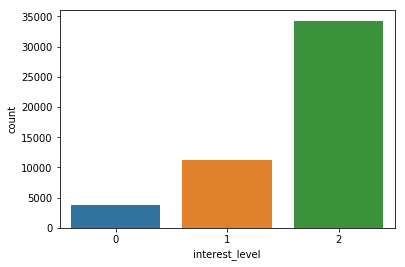

In [6]:
sns.countplot(train['interest_level'])
plt.show()

三分类问题, 各分类不均衡

## 数据量太大,分割数据
train = train.sample(frac=0.3)
train.shape

In [7]:
# 区分测试集与训练集
X = train.drop('interest_level', axis=1)
y = train['interest_level']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y
    , test_size=0.2
    , random_state=33
    , stratify=y)

# XGboost调参

## 初步确定n_estimators

In [8]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=33)

In [9]:
xgb_param = xgb1.get_xgb_params()
xgb_param['num_class'] = 3
xgtrain = xgb.DMatrix(X_train, label = y_train)
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=33)


In [10]:
cvresult = xgb.cv(xgb_param
                  , xgtrain
                  , num_boost_round=1000
                  , folds = folds
                  , show_stdv=False 
                  , verbose_eval=10
                  , metrics='mlogloss'
                  , early_stopping_rounds=10)



[0]	train-mlogloss:1.03936	test-mlogloss:1.04028
[10]	train-mlogloss:0.749494	test-mlogloss:0.757624
[20]	train-mlogloss:0.661208	test-mlogloss:0.675322
[30]	train-mlogloss:0.625107	test-mlogloss:0.645004
[40]	train-mlogloss:0.604088	test-mlogloss:0.629631
[50]	train-mlogloss:0.590335	test-mlogloss:0.621066
[60]	train-mlogloss:0.578884	test-mlogloss:0.614762
[70]	train-mlogloss:0.569619	test-mlogloss:0.610515
[80]	train-mlogloss:0.561775	test-mlogloss:0.607549
[90]	train-mlogloss:0.55453	test-mlogloss:0.60483
[100]	train-mlogloss:0.548143	test-mlogloss:0.603209
[110]	train-mlogloss:0.541802	test-mlogloss:0.601767
[120]	train-mlogloss:0.535704	test-mlogloss:0.600354
[130]	train-mlogloss:0.530387	test-mlogloss:0.599434
[140]	train-mlogloss:0.524941	test-mlogloss:0.598528
[150]	train-mlogloss:0.519981	test-mlogloss:0.597765
[160]	train-mlogloss:0.515338	test-mlogloss:0.597261
[170]	train-mlogloss:0.510346	test-mlogloss:0.596604
[180]	train-mlogloss:0.505942	test-mlogloss:0.596066
[190]	tr

In [11]:
cvresult

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.040283,0.000103,1.039361,0.000388
1,0.990873,0.000602,0.988979,0.000923
2,0.948088,0.000225,0.945611,0.000752
3,0.911337,0.000356,0.908071,0.000652
4,0.879852,0.000607,0.875819,0.000686
5,0.852490,0.000266,0.847851,0.000966
6,0.828306,0.000435,0.822997,0.000923
7,0.806798,0.000792,0.800829,0.000785
8,0.788736,0.001278,0.782112,0.001327
9,0.772114,0.001399,0.764728,0.001546


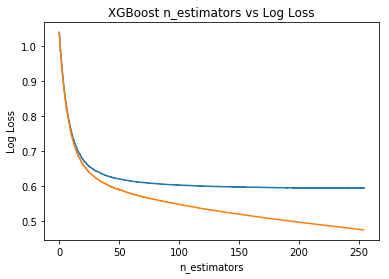

In [12]:
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = cvresult.index
        
plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )

plt.show()

## 初步确定'max_depth' and 'min_child_weight'

In [13]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [14]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)



In [15]:
# 暴力搜索
gsearch2 = GridSearchCV(xgb2
                        , param_grid = param_test2
                        , scoring='neg_log_loss'
                        , n_jobs=-1
                        , cv=kfold
                        , return_train_score=True)

gsearch2.fit(X_train , y_train)

gsearch2.grid_scores_

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.59922, std: 0.00458, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: -0.59922, std: 0.00436, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: -0.59914, std: 0.00418, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: -0.59110, std: 0.00376, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: -0.59056, std: 0.00335, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: -0.59032, std: 0.00402, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: -0.59454, std: 0.00389, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: -0.59458, std: 0.00357, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: -0.59269, std: 0.00245, params: {'max_depth': 7, 'min_child_weight': 5},
 mean: -0.61136, std: 0.00325, params: {'max_depth': 9, 'min_child_weight': 1},
 mean: -0.60591, std: 0.00431, params: {'max_depth': 9, 'min_child_weight': 3},
 mean: -0.60338, std: 0.00366, params: {'max_depth': 9, 'min_child_weight': 5}]

In [16]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 5}, -0.5903179219332552)

In [17]:
max_depth = gsearch2.best_params_["max_depth"]
min_child_weight = gsearch2.best_params_["min_child_weight"]
max_depth, min_child_weight

(5, 5)

## 再次确定'max_depth' and 'min_child_weight'

In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
max_depth = [max_depth-1, max_depth, max_depth+1]
if min_child_weight==1:
    min_child_weight = [1,2]
else:
    min_child_weight = [min_child_weight-1,min_child_weight,min_child_weight+1]
param_test3 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test3

{'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]}

In [19]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)



In [20]:

gsearch3 = GridSearchCV(xgb3, param_grid = param_test3, 
                        scoring='neg_log_loss',
                        n_jobs=-1, 
                        cv=kfold, 
                        return_train_score=True, )
gsearch3.fit(X_train , y_train)

gsearch3.grid_scores_, 

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59263, std: 0.00446, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.59301, std: 0.00461, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.59233, std: 0.00409, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.59060, std: 0.00318, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.59032, std: 0.00402, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.59102, std: 0.00368, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.59073, std: 0.00290, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.59194, std: 0.00312, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.59032, std: 0.00288, params: {'max_depth': 6, 'min_child_weight': 6}],)

In [21]:
gsearch3.best_params_,     gsearch3.best_score_

({'max_depth': 5, 'min_child_weight': 5}, -0.5903179219332552)

## 再次确定n_estimators

In [22]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult.shape[0],
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=33)

In [23]:
xgb_param = xgb4.get_xgb_params()
xgb_param['num_class'] = 3
xgtrain = xgb.DMatrix(X_train, label = y_train)
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=33)


In [24]:
cvresult2 = xgb.cv(xgb_param
                  , xgtrain
                  , num_boost_round=1000
                  , folds = folds
                  , show_stdv=False 
                  , verbose_eval=10
                  , metrics='mlogloss'
                  , early_stopping_rounds=10)



[0]	train-mlogloss:1.0395	test-mlogloss:1.04032
[10]	train-mlogloss:0.750327	test-mlogloss:0.757596
[20]	train-mlogloss:0.662836	test-mlogloss:0.67565
[30]	train-mlogloss:0.627354	test-mlogloss:0.645376
[40]	train-mlogloss:0.607295	test-mlogloss:0.630265
[50]	train-mlogloss:0.594051	test-mlogloss:0.621381
[60]	train-mlogloss:0.583005	test-mlogloss:0.614876
[70]	train-mlogloss:0.574276	test-mlogloss:0.610502
[80]	train-mlogloss:0.567361	test-mlogloss:0.607542
[90]	train-mlogloss:0.560855	test-mlogloss:0.604699
[100]	train-mlogloss:0.555442	test-mlogloss:0.603034
[110]	train-mlogloss:0.549873	test-mlogloss:0.601595
[120]	train-mlogloss:0.544263	test-mlogloss:0.60016
[130]	train-mlogloss:0.539681	test-mlogloss:0.599276
[140]	train-mlogloss:0.534881	test-mlogloss:0.598553
[150]	train-mlogloss:0.530509	test-mlogloss:0.597732
[160]	train-mlogloss:0.526343	test-mlogloss:0.597161
[170]	train-mlogloss:0.521923	test-mlogloss:0.596398
[180]	train-mlogloss:0.518201	test-mlogloss:0.596203
[190]	tra

In [25]:
cvresult2

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.040320,0.000099,1.039495,0.000333
1,0.990850,0.000566,0.989165,0.000849
2,0.948111,0.000277,0.945842,0.000740
3,0.911427,0.000351,0.908361,0.000645
4,0.879812,0.000659,0.876183,0.000644
5,0.852432,0.000426,0.848292,0.000876
6,0.828317,0.000539,0.823585,0.000919
7,0.806850,0.000866,0.801519,0.000771
8,0.788773,0.001308,0.782856,0.001326
9,0.772092,0.001407,0.765540,0.001563


## 行列采样

In [26]:
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3

{'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}

In [27]:
xgb5 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult2.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

In [28]:

gsearch5 = GridSearchCV(xgb5, param_grid = param_test3, 
                        scoring='neg_log_loss',
                        n_jobs=-1, 
                        cv=kfold, 
                        return_train_score=True, )
gsearch5.fit(X_train , y_train)

gsearch5.grid_scores_

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.59072, std: 0.00387, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
 mean: -0.58811, std: 0.00332, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
 mean: -0.58681, std: 0.00348, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
 mean: -0.58633, std: 0.00314, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
 mean: -0.58624, std: 0.00350, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
 mean: -0.58522, std: 0.00270, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: -0.58992, std: 0.00335, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
 mean: -0.58849, std: 0.00323, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
 mean: -0.58721, std: 0.00307, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
 mean: -0.58619, std: 0.00270, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
 mean: -0.58621, std: 0.00342, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
 mean: -0.58642, std: 0.00348, params: {'colsample_bytree': 0.7, 'subsample'

In [29]:
gsearch5.best_params_,     gsearch5.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, -0.584848091456824)

## 初步设置正则参数 

In [30]:
reg_alpha = [0, 1, 1.5, 2]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.1, 0.5, 1, 2]      #default = 1，测试0.1， 0.5， 1，2

param_test6 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test6

{'reg_alpha': [0, 1, 1.5, 2], 'reg_lambda': [0.1, 0.5, 1, 2]}

In [31]:
xgb6 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult2.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=gsearch5.best_params_['subsample'],
        colsample_bytree=gsearch5.best_params_['colsample_bytree'],
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

In [32]:

gsearch6 = GridSearchCV(xgb6, param_grid = param_test6, 
                        scoring='neg_log_loss',
                        n_jobs=-1, 
                        cv=kfold, 
                        return_train_score=True, )
gsearch6.fit(X_train , y_train)

gsearch6.grid_scores_, 

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58520, std: 0.00330, params: {'reg_alpha': 0, 'reg_lambda': 0.1},
  mean: -0.58532, std: 0.00287, params: {'reg_alpha': 0, 'reg_lambda': 0.5},
  mean: -0.58485, std: 0.00297, params: {'reg_alpha': 0, 'reg_lambda': 1},
  mean: -0.58500, std: 0.00320, params: {'reg_alpha': 0, 'reg_lambda': 2},
  mean: -0.58422, std: 0.00277, params: {'reg_alpha': 1, 'reg_lambda': 0.1},
  mean: -0.58452, std: 0.00285, params: {'reg_alpha': 1, 'reg_lambda': 0.5},
  mean: -0.58462, std: 0.00310, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: -0.58496, std: 0.00253, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.58450, std: 0.00291, params: {'reg_alpha': 1.5, 'reg_lambda': 0.1},
  mean: -0.58460, std: 0.00326, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.58445, std: 0.00304, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.58514, std: 0.00279, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.58458, std: 0.00312, params: {'reg_alpha': 2, 'reg_lambda': 0.1},
  m

In [33]:
gsearch6.best_params_,     gsearch6.best_score_

({'reg_alpha': 1, 'reg_lambda': 0.1}, -0.5842174672770901)

正则参数调整后neg_log_loss反而变大, 还是选用默认正则参数

## 最终参数

In [34]:
xgb7 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult2.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=gsearch5.best_params_['subsample'],
        colsample_bytree=gsearch5.best_params_['colsample_bytree'],
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        reg_alpha  = gsearch6.best_params_['reg_alpha'],
        reg_lambda = gsearch6.best_params_['reg_lambda'],
        seed=3)

In [35]:
xgb7.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=255,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=1, reg_lambda=0.1, scale_pos_weight=1, seed=3,
       silent=True, subsample=0.8)

In [36]:
y_pred = xgb7.predict(X_test)
xgb7.score(X_test, y_test)

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7427818863337048

In [37]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.58      0.28      0.38       768
          1       0.49      0.32      0.39      2246
          2       0.80      0.93      0.86      6857

avg / total       0.71      0.74      0.71      9871



# 预测保存

In [38]:
submission_xgb = test.loc[:,['Year','Month', 'Day', 'Wday', 'Yday', 'hour']]
#submission

In [39]:
y_ptrdict = xgb7.predict(test)

/home/zhou/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [40]:
submission_xgb['interest_level']= y_ptrdict
submission_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Data columns (total 7 columns):
Year              74659 non-null int64
Month             74659 non-null int64
Day               74659 non-null int64
Wday              74659 non-null int64
Yday              74659 non-null int64
hour              74659 non-null int64
interest_level    74659 non-null int64
dtypes: int64(7)
memory usage: 4.0 MB


In [43]:
submission_xgb.to_csv(dpath+'submission_xgb.csv')

In [44]:
submission_crat=pd.read_csv(dpath+'submission_crat.csv')

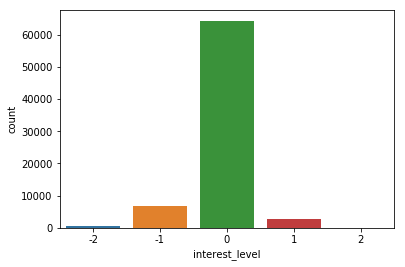

In [45]:
sns.countplot(submission_xgb['interest_level']-submission_crat['interest_level'])